###  Estimating the effect of new editors/owners on Newspaper Coverage

In [ ]:
# add publisher and editor change information to Master.csv
# NOW SPLITS editor_and_publisher_change into:
#   - editor_and_publisher_change_same_year
#   - editor_and_publisher_change_diff_year

import pandas as pd
import re

# Load the data
df = pd.read_csv('data/master.csv')

# Define the years we're tracking
years = [1869, 1871, 1872, 1873, 1876, 1877, 1878, 1879, 1880, 1882, 1883, 1884, 1885, 1890]

def levenshtein_distance(s1, s2):
    """Calculate the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    prev_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        curr_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = prev_row[j + 1] + 1
            deletions = curr_row[j] + 1
            substitutions = prev_row[j] + (c1 != c2)
            curr_row.append(min(insertions, deletions, substitutions))
        prev_row = curr_row
    return prev_row[-1]

def strings_match(s1, s2, max_distance=1):
    """Check if two strings match within max_distance edits."""
    s1_clean = s1.strip().lower()
    s2_clean = s2.strip().lower()
    if s1_clean == s2_clean:
        return True
    return levenshtein_distance(s1_clean, s2_clean) <= max_distance

def tokenize_publisher(publisher_str):
    if not publisher_str:
        return []
    cleaned = re.sub(r'[;,]', ' ', publisher_str)
    tokens = cleaned.split()
    return [t.strip() for t in tokens if len(t.strip()) >= 4]

def publishers_match_tokenized(pub1, pub2):
    tokens1 = tokenize_publisher(pub1)
    tokens2 = tokenize_publisher(pub2)
    if not tokens1 or not tokens2:
        return False
    for t1 in tokens1:
        for t2 in tokens2:
            if strings_match(t1, t2, max_distance=1):
                return True
    return False

def normalize_publisher(pub):
    if not pub:
        return ""
    return re.sub(r'[^a-z0-9]', '', pub.lower())

def publishers_match_normalized(pub1, pub2):
    n1 = normalize_publisher(pub1)
    n2 = normalize_publisher(pub2)
    if not n1 or not n2:
        return False
    return n1 == n2 or n1 in n2 or n2 in n1

def names_match(name1, name2):
    return publishers_match_tokenized(name1, name2) or publishers_match_normalized(name1, name2)

def clean_field(value):
    if pd.isna(value):
        return ''
    s = str(value).strip()
    if s.lower() == 'nan':
        return ''
    return s

def detect_first_change(data_points):
    for i in range(1, len(data_points)):
        prev_year, prev_val = data_points[i - 1]
        curr_year, curr_val = data_points[i]
        if not names_match(prev_val, curr_val):
            return curr_year
    return None

def analyze_changes(row):
    """
    Analyze a newspaper row for publisher and editor changes.
    Returns: (category, publisher_change_year, editor_change_year)
    Categories:
      - 'insufficient_data'
      - 'no_change'
      - 'publisher_change_only'
      - 'editor_change_only'
      - 'editor_and_publisher_change_same_year'   <-- NEW
      - 'editor_and_publisher_change_diff_year'   <-- NEW
    """
    pub_data = []
    ed_data = []
    for year in years:
        publisher = clean_field(row.get(f'{year} publisher', ''))
        editor = clean_field(row.get(f'{year} editor', ''))
        if publisher:
            pub_data.append((year, publisher))
        if editor:
            ed_data.append((year, editor))

    has_enough_pub = len(pub_data) >= 3
    has_enough_ed = len(ed_data) >= 3

    if not has_enough_pub and not has_enough_ed:
        return ('insufficient_data', None, None)

    pub_change_year = detect_first_change(pub_data) if has_enough_pub else None
    ed_change_year = detect_first_change(ed_data) if has_enough_ed else None

    has_pub_change = pub_change_year is not None
    has_ed_change = ed_change_year is not None

    if has_pub_change and has_ed_change:
        if pub_change_year == ed_change_year:
            category = 'editor_and_publisher_change_same_year'
        else:
            category = 'editor_and_publisher_change_diff_year'
    elif has_pub_change:
        category = 'publisher_change_only'
    elif has_ed_change:
        category = 'editor_change_only'
    else:
        category = 'no_change'

    return (category, pub_change_year, ed_change_year)

# Apply analysis to each row
results = df.apply(analyze_changes, axis=1)
df['category'] = results.apply(lambda x: x[0])
df['publisher_change_year'] = results.apply(lambda x: x[1])
df['editor_change_year'] = results.apply(lambda x: x[2])

# Filter out insufficient data
valid_df = df[df['category'] != 'insufficient_data'].copy()

# Count categories
category_counts = valid_df['category'].value_counts()

print("=" * 60)
print("PUBLISHER & EDITOR CHANGE ANALYSIS RESULTS")
print("=" * 60)
print(f"\nTotal newspapers analyzed: {len(df)}")
print(f"Newspapers with at least 4 years of data: {len(valid_df)}")
print(f"Newspapers with insufficient data: {len(df) - len(valid_df)}")
print("\n" + "-" * 40)
print("CATEGORY BREAKDOWN:")
print("-" * 40)

category_labels = {
    'editor_and_publisher_change_same_year': 'Editor & publisher changed (same year)',
    'editor_and_publisher_change_diff_year': 'Editor & publisher changed (diff years)',
    'publisher_change_only': 'Publisher changed only',
    'editor_change_only': 'Editor changed only',
    'no_change': 'No change detected',
}

for cat, label in category_labels.items():
    count = category_counts.get(cat, 0)
    pct = (count / len(valid_df) * 100) if len(valid_df) > 0 else 0
    print(f"{label}: {count} ({pct:.1f}%)")

# Save updated CSV
df.to_csv('data/master.csv', index=False)
print("\n" + "=" * 60)
print("Updated master.csv with 'category', 'publisher_change_year', and 'editor_change_year' columns")
print("=" * 60)

# Show sample of newspapers with changes
print("\n" + "-" * 40)
print("SAMPLE: Newspapers with changes")
print("-" * 40)
change_categories = list(category_labels.keys())
change_categories.remove('no_change')
changes_df = valid_df[valid_df['category'].isin(change_categories)]
if len(changes_df) > 0:
    sample_cols = ['state', 'town', 'newspaper_name', 'category', 'publisher_change_year', 'editor_change_year']
    print(changes_df[sample_cols].head(10).to_string(index=False))
else:
    print("No changes found.")

# Create lists for each category
publisher_change_only_list = valid_df[valid_df['category'] == 'publisher_change_only'][
    ['state', 'town', 'newspaper_name', 'publisher_change_year']
]
editor_change_only_list = valid_df[valid_df['category'] == 'editor_change_only'][
    ['state', 'town', 'newspaper_name', 'editor_change_year']
]
editor_and_publisher_same_list = valid_df[valid_df['category'] == 'editor_and_publisher_change_same_year'][
    ['state', 'town', 'newspaper_name', 'publisher_change_year', 'editor_change_year']
]
editor_and_publisher_diff_list = valid_df[valid_df['category'] == 'editor_and_publisher_change_diff_year'][
    ['state', 'town', 'newspaper_name', 'publisher_change_year', 'editor_change_year']
]
no_change_list = valid_df[valid_df['category'] == 'no_change'][
    ['state', 'town', 'newspaper_name']
]

print("\n" + "=" * 60)
print("DataFrames created:")
print("  - publisher_change_only_list")
print("  - editor_change_only_list")
print("  - editor_and_publisher_same_list")
print("  - editor_and_publisher_diff_list")
print("  - no_change_list")
print("=" * 60)

C:\Users\samwt\AppData\Local\Temp\ipykernel_20012\3145179763.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Archive/master.csv')


PUBLISHER & EDITOR CHANGE ANALYSIS RESULTS

Total newspapers analyzed: 47956
Newspapers with at least 4 years of data: 12397
Newspapers with insufficient data: 35559

----------------------------------------
CATEGORY BREAKDOWN:
----------------------------------------
Editor & publisher changed (same year): 5014 (40.4%)
Editor & publisher changed (diff years): 851 (6.9%)
Publisher changed only: 794 (6.4%)
Editor changed only: 674 (5.4%)
No change detected: 5064 (40.8%)

Updated master.csv with 'category', 'publisher_change_year', and 'editor_change_year' columns

----------------------------------------
SAMPLE: Newspapers with changes
----------------------------------------
state      town     newspaper_name                              category  publisher_change_year  editor_change_year
  NaN  Abingdon  Knox Co. Democrat                 publisher_change_only                 1872.0                 NaN
  NaN     Afton            Tribane editor_and_publisher_change_same_year            

In [23]:
# filter down to newspapers that we can match 

import pandas as pd

master = pd.read_csv("data/master.csv")
matches = pd.read_csv("data/matches.csv")

matches["publisher_change_year"] = matches["master_id"].dropna().astype(int).map(master["publisher_change_year"])
matches["editor_change_year"] = matches["master_id"].dropna().astype(int).map(master["editor_change_year"])
matches["category"] = matches["master_id"].dropna().astype(int).map(master["category"])
matches = matches[matches.master_id.notna()]
matches.to_csv("data/final_list.csv", index=False)

print(f"Rows with master_id: {matches['master_id'].notna().sum()}")
print(f"Rows with publisher_change_year: {matches['publisher_change_year'].notna().sum()}")

print(len(matches[matches.category.str.contains('editor_change_only')]))
print(len(matches[matches.category.str.contains('publisher_change_only')]))

C:\Users\samwt\AppData\Local\Temp\ipykernel_20012\1763648295.py:5: DtypeWarning: Columns (10,96) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv("data/master.csv")


Rows with master_id: 521
Rows with publisher_change_year: 242
28
38


In [28]:
# structural drift panel creation — multi-treatment DID
# Updated: uses editor_and_publisher_change_same_year only
#          (drops editor_and_publisher_change_diff_year observations)
# Updated: topic_counts keyed by issn

import pandas as pd
import json
import numpy as np

# Load data sources
newspapers = pd.read_csv('data/final_list.csv')
with open('data/topic_counts.json', 'r') as f:
    topic_data = json.load(f)

TOPICS = [
    'labor_workers', 'politics_elections', 'congress_government',
    'business_commerce', 'railroads_transportation', 'agriculture_farming',
    'courts_law', 'finance_money', 'immigration_foreign', 'crime_police'
]

# Only these three categories are treated; diff-year papers are excluded entirely
TREATMENT_CATEGORIES = [
    'publisher_change_only',
    'editor_change_only',
    'editor_and_publisher_change_same_year',
]

# =============================================================================
# Step 1: Build raw panel with topic rates per 1,000 headlines
# =============================================================================
records = []
for year, papers in topic_data.items():
    for issn, data in papers.items():
        if 'topic_counts' in data and 'total_headlines' in data:
            total = data['total_headlines']
            if total >= 75:
                record = {
                    'year': int(year),
                    'issn': issn
                }
                for topic in TOPICS:
                    count = data['topic_counts'].get(topic, 0)
                    record[topic] = (count / total) * 1000
                records.append(record)

panel = pd.DataFrame(records)

# Merge with metadata
panel = panel.merge(
    newspapers[[
        'issn', 'master_id', 'master_name',
        'category', 'publisher_change_year', 'editor_change_year'
    ]],
    on='issn', how='left'
)

# =============================================================================
# Step 1.5: Drop diff-year papers entirely so they don't pollute control group
# =============================================================================
n_before = panel['master_id'].nunique()
panel = panel[panel['category'] != 'editor_and_publisher_change_diff_year'].copy()
n_after = panel['master_id'].nunique()
print(f"Dropped {n_before - n_after} diff-year papers from panel")

# =============================================================================
# Step 2: Determine treatment status and treatment year per paper
# =============================================================================
panel['is_treated'] = panel['category'].isin(TREATMENT_CATEGORIES)

def get_treatment_year(row):
    """Return the earliest change year for a treated paper, or NaN for control."""
    if row['category'] not in TREATMENT_CATEGORIES:
        return np.nan
    years = []
    if pd.notna(row['publisher_change_year']):
        years.append(row['publisher_change_year'])
    if pd.notna(row['editor_change_year']):
        years.append(row['editor_change_year'])
    return min(years) if years else np.nan

panel['treatment_year'] = panel.apply(get_treatment_year, axis=1)

# Adjust: subtract 1 so the treatment year marks the last pre-treatment year
panel['treatment_year'] = panel['treatment_year'] - 1

median_treat_year = panel.loc[panel['is_treated'], 'treatment_year'].median()

print(f"Median treatment year among treated papers: "
      f"{panel.loc[panel['is_treated'], 'treatment_year'].median()}")

# =============================================================================
# Step 3: Create treatment group dummies
# =============================================================================
for cat in TREATMENT_CATEGORIES:
    panel[f'is_{cat}'] = (panel['category'] == cat).astype(int)

# =============================================================================
# Step 4: Define anchor cutoff year for each paper
#         Treated  → treatment_year (already set above)
#         Control  → max(first_year + 3, individual median year)
# =============================================================================
panel = panel.dropna(subset=['master_id']).copy()
paper_stats = panel.groupby('master_id')['year'].agg(['min', 'median'])
paper_stats.columns = ['first_year', 'median_year']
panel = panel.merge(paper_stats, on='master_id', how='left')

panel['anchor_cutoff'] = np.where(
    panel['is_treated'],
    panel['treatment_year'],
    np.maximum(panel['first_year'] + 3, panel['median_year'])
).astype(int)

panel.drop(columns=['first_year', 'median_year'], inplace=True)

# =============================================================================
# Step 5: Filter papers with at least 3 pre-treatment years
# =============================================================================
pre_counts = panel[panel['year'] < panel['anchor_cutoff']].groupby('master_id').size()
valid_papers = pre_counts[pre_counts >= 3].index
panel = panel[panel['master_id'].isin(valid_papers)].copy()
print(f"Papers with ≥3 pre-treatment years: {len(valid_papers)}")

# =============================================================================
# Step 6: Calculate anchor vector (pre-treatment average) for each paper
# =============================================================================
pre_panel = panel[panel['year'] < panel['anchor_cutoff']]
anchors = pre_panel.groupby('master_id')[TOPICS].mean()
anchors.columns = [f'anchor_{t}' for t in TOPICS]

panel = panel.merge(anchors, on='master_id', how='left')

# =============================================================================
# Step 7: Calculate Y_it = Euclidean distance from anchor
# =============================================================================
def calc_drift(row):
    sq_diffs = sum((row[t] - row[f'anchor_{t}'])**2 for t in TOPICS)
    return np.sqrt(sq_diffs)

panel['Y_it'] = panel.apply(calc_drift, axis=1)

# =============================================================================
# Step 8: Create Post_it dummy and interaction terms
# =============================================================================
panel['Post_it'] = (panel['year'] >= panel['anchor_cutoff']).astype(int)

for cat in TREATMENT_CATEGORIES:
    panel[f'Post_x_{cat}'] = panel['Post_it'] * panel[f'is_{cat}']

# =============================================================================
# Step 9: Event-study relative time variable
# =============================================================================
panel['rel_year'] = panel['year'] - panel['anchor_cutoff']

# =============================================================================
# Step 10: Build final output table
# =============================================================================
output_cols = [
    'master_id', 'master_name', 'year', 'category',
    'is_treated', 'anchor_cutoff', 'Post_it', 'Y_it', 'rel_year',
] + [f'is_{cat}' for cat in TREATMENT_CATEGORIES] \
  + [f'Post_x_{cat}' for cat in TREATMENT_CATEGORIES]

output = panel[output_cols].rename(columns={
    'master_id': 'Newspaper_ID',
    'master_name': 'Newspaper_Name',
    'year': 'Year',
    'anchor_cutoff': 'Anchor_Cutoff_Year',
    'rel_year': 'Rel_Year',
}).sort_values(['Newspaper_ID', 'Year']).reset_index(drop=True)

# Display diagnostics
print("\nSample of final panel:\n")
print(output.head(20).to_string(index=False))

print(f"\n--- Panel Summary ---")
print(f"Total observations: {len(output)}")
print(f"Unique newspapers: {output['Newspaper_ID'].nunique()}")

treated_counts = panel[panel['is_treated']].groupby('category')['master_id'].nunique()
control_count = panel[~panel['is_treated']]['master_id'].nunique()
print(f"Control papers (no_change): {control_count}")
for cat in TREATMENT_CATEGORIES:
    count = treated_counts.get(cat, 0)
    print(f"Treated papers ({cat}): {count}")

print(f"Pre-treatment obs: {(output['Post_it'] == 0).sum()}")
print(f"Post-treatment obs: {(output['Post_it'] == 1).sum()}")

# Save
output.to_csv('data/panel_structural_drift.csv', index=False)
print("\nSaved to 'panel_structural_drift.csv'")

Dropped 27 diff-year papers from panel
Median treatment year among treated papers: 1876.0
Papers with ≥3 pre-treatment years: 325

Sample of final panel:

 Newspaper_ID                               Newspaper_Name  Year          category  is_treated  Anchor_Cutoff_Year  Post_it       Y_it  Rel_Year  is_publisher_change_only  is_editor_change_only  is_editor_and_publisher_change_same_year  Post_x_publisher_change_only  Post_x_editor_change_only  Post_x_editor_and_publisher_change_same_year
          4.0 Meridional.tt ALEXANDRIA, Louisiana Democrat  1877 insufficient_data       False                1883        0  42.951005        -6                         0                      0                                         0                             0                          0                                             0
          4.0 Meridional.tt ALEXANDRIA, Louisiana Democrat  1878 insufficient_data       False                1883        0  11.705858        -5                       

MODEL 1: STATIC DiD — Treatment Effects by Group

  Publisher Change Only:
    β:              4.1658
    Std Error (CR): 2.4198
    95% CI (CR):    [-0.5769, 8.9085]
    P-value (CR):   0.0852
    P-value (WCB):  0.0907

  Editor Change Only:
    β:              6.1826
    Std Error (CR): 5.2008
    95% CI (CR):    [-4.0108, 16.3760]
    P-value (CR):   0.2345
    P-value (WCB):  0.3286

  Editor & Publisher (Same Year):
    β:              6.0320
    Std Error (CR): 1.6071
    95% CI (CR):    [2.8821, 9.1820]
    P-value (CR):   0.0002
    P-value (WCB):  0.0004

  R-squared:    0.5537
  Observations: 3668

MODEL 2: EVENT STUDY — Dynamic Effects by Treatment Group
  (WCB = wild cluster bootstrap p-value)

  Publisher Change Only:
 k    beta  ci_low  ci_high  pval_CR  pval_WCB
-5  3.2835 -1.7670   8.3340   0.2026    0.2072
-4  4.3072 -0.9424   9.5568   0.1078    0.1087
-3 -0.7892 -6.5936   5.0152   0.7899    0.7962
-2 -3.6690 -9.2680   1.9299   0.1990    0.2187
-1  0.0000  0.0000   0.

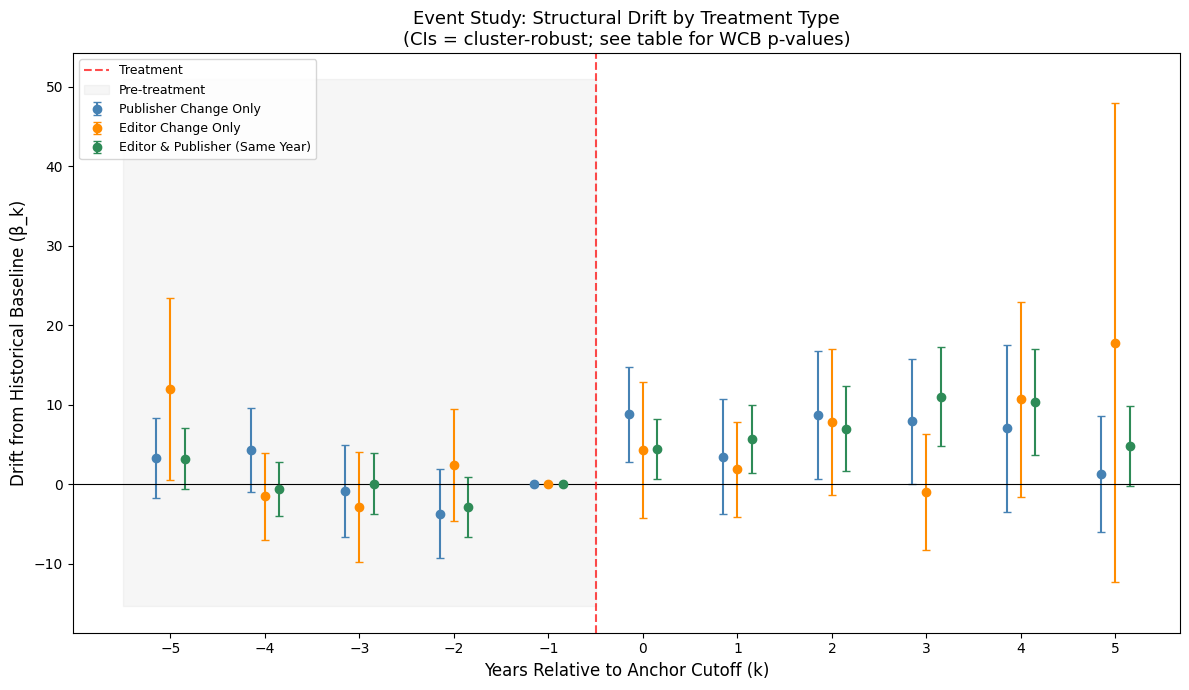

In [25]:
# regression — multi-treatment DID with wild cluster bootstrap
# pip install wildboottest  (if not already installed)

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from wildboottest.wildboottest import WildboottestCL
HAS_WB = True

# Load the structural drift panel
panel = pd.read_csv('data/panel_structural_drift.csv')

# Updated treatment categories with same/diff year split
TREATMENT_CATEGORIES = [
    'publisher_change_only',
    'editor_change_only',
    'editor_and_publisher_change_same_year',
]

TREATMENT_LABELS = {
    'publisher_change_only': 'Publisher Change Only',
    'editor_change_only': 'Editor Change Only',
    'editor_and_publisher_change_same_year': 'Editor & Publisher (Same Year)',
}

TREATMENT_COLORS = {
    'publisher_change_only': 'steelblue',
    'editor_change_only': 'darkorange',
    'editor_and_publisher_change_same_year': 'seagreen',
}

# ---- Rebuild treatment dummies for the new split ----
# If the panel still has the old 'editor_and_publisher_change' category,
# we need to update is_treated and the group dummies.
for cat in TREATMENT_CATEGORIES:
    panel[f'is_{cat}'] = (panel['category'] == cat).astype(int)

panel['is_treated'] = panel['category'].isin(TREATMENT_CATEGORIES)

# Rebuild Post x Treatment interactions
for cat in TREATMENT_CATEGORIES:
    panel[f'Post_x_{cat}'] = panel['Post_it'] * panel[f'is_{cat}']

# =============================================================================
# Helper: wild cluster bootstrap p-value for a single coefficient
# =============================================================================
def wild_bootstrap_pvalue(y, X, cluster_ids, coef_name, B=9999, seed=42):
    """
    Run wild cluster bootstrap (Rademacher weights) for a single coefficient
    using WildboottestCL from wildboottest package.
    Returns (original_coef, bootstrap_p_value).
    """
    if not HAS_WB:
        return None, None

    y_arr = np.asarray(y, dtype=float).ravel()
    X_arr = np.asarray(X, dtype=float)
    col_names = list(X.columns) if hasattr(X, 'columns') else [str(i) for i in range(X_arr.shape[1])]

    if coef_name not in col_names:
        return None, None
    param_idx = col_names.index(coef_name)

    cluster_arr = pd.Categorical(cluster_ids).codes.astype(np.int32)

    # Build restriction vector: test that coefficient param_idx = 0
    R = np.zeros(X_arr.shape[1])
    R[param_idx] = 1

    try:
        wb = WildboottestCL(
            X=X_arr,
            Y=y_arr,
            cluster=cluster_arr,
            R=R,
            B=B,
            seed=seed,
        )
        wb.get_scores(bootstrap_type="11", impose_null=True)
        wb.get_weights(weights_type="rademacher")
        wb.get_numer()
        wb.get_denom()
        wb.get_tboot()
        wb.get_vcov()
        wb.get_tstat()
        wb.get_pvalue(pval_type="two-tailed")

        return wb.t_stat, wb.pvalue
    except Exception as e:
        print(f"  Wild bootstrap failed for {coef_name}: {e}")
        return None, None

# =============================================================================
# Model 1: Static DiD — Separate coefficients per treatment arm
# =============================================================================
post_x_terms = [f'Post_x_{cat}' for cat in TREATMENT_CATEGORIES]
reg_data = panel[['Newspaper_ID', 'Year', 'Y_it'] + post_x_terms].dropna().copy()

news_dummies = pd.get_dummies(reg_data['Newspaper_ID'], prefix='news', drop_first=True, dtype=float)
year_dummies = pd.get_dummies(reg_data['Year'], prefix='yr', drop_first=True, dtype=float)
X_static = pd.concat([reg_data[post_x_terms].reset_index(drop=True),
                       news_dummies.reset_index(drop=True),
                       year_dummies.reset_index(drop=True)], axis=1)
X_static = sm.add_constant(X_static)
y_static = reg_data['Y_it'].reset_index(drop=True)
groups_static = reg_data['Newspaper_ID'].reset_index(drop=True)

static_model = sm.OLS(y_static, X_static).fit(
    cov_type='cluster', cov_kwds={'groups': groups_static}
)

print("=" * 70)
print("MODEL 1: STATIC DiD — Treatment Effects by Group")
print("=" * 70)

for cat in TREATMENT_CATEGORIES:
    var = f'Post_x_{cat}'
    if var not in static_model.params:
        print(f"\n  {TREATMENT_LABELS[cat]}: (no observations or collinear — skipped)")
        continue
    ci = static_model.conf_int().loc[var]

    # Wild cluster bootstrap
    wb_coef, wb_pval = wild_bootstrap_pvalue(
        y_static, X_static, groups_static, var
    )

    print(f"\n  {TREATMENT_LABELS[cat]}:")
    print(f"    β:              {static_model.params[var]:.4f}")
    print(f"    Std Error (CR): {static_model.bse[var]:.4f}")
    print(f"    95% CI (CR):    [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"    P-value (CR):   {static_model.pvalues[var]:.4f}")
    if wb_pval is not None:
        print(f"    P-value (WCB):  {wb_pval:.4f}")

print(f"\n  R-squared:    {static_model.rsquared:.4f}")
print(f"  Observations: {int(static_model.nobs)}")

# =============================================================================
# Model 2: Event Study (Dynamic Effects) — per treatment arm
# =============================================================================
K_MIN, K_MAX = -5, 5
REF_K = -1

panel['Time_to_Treat'] = panel['Year'] - panel['Anchor_Cutoff_Year']

def bin_time(k):
    if pd.isna(k):
        return None
    if k < K_MIN:
        return K_MIN
    if k > K_MAX:
        return K_MAX
    return int(k)

panel['event_k'] = panel['Time_to_Treat'].apply(bin_time)

# Create interaction dummies: event_k × treatment_group
interaction_cols = []
for cat in TREATMENT_CATEGORIES:
    is_cat = panel[f'is_{cat}']
    for k in range(K_MIN, K_MAX + 1):
        if k == REF_K:
            continue
        k_label = f'n{abs(k)}' if k < 0 else str(k)
        col_name = f'ev_{cat}_k{k_label}'
        panel[col_name] = ((panel['event_k'] == k) & (is_cat == 1)).astype(int)
        interaction_cols.append(col_name)

reg_data_es = panel[['Newspaper_ID', 'Year', 'Y_it'] + interaction_cols].dropna().copy()

news_dummies_es = pd.get_dummies(reg_data_es['Newspaper_ID'], prefix='news', drop_first=True, dtype=float)
year_dummies_es = pd.get_dummies(reg_data_es['Year'], prefix='yr', drop_first=True, dtype=float)
X_es = pd.concat([reg_data_es[interaction_cols].reset_index(drop=True),
                   news_dummies_es.reset_index(drop=True),
                   year_dummies_es.reset_index(drop=True)], axis=1)
X_es = sm.add_constant(X_es)
y_es = reg_data_es['Y_it'].reset_index(drop=True)
groups_es = reg_data_es['Newspaper_ID'].reset_index(drop=True)

event_model = sm.OLS(y_es, X_es).fit(
    cov_type='cluster', cov_kwds={'groups': groups_es}
)

# Extract coefficients per treatment group + wild bootstrap p-values
print("\n" + "=" * 70)
print("MODEL 2: EVENT STUDY — Dynamic Effects by Treatment Group")
print("  (WCB = wild cluster bootstrap p-value)")
print("=" * 70)

all_coefs = {}
for cat in TREATMENT_CATEGORIES:
    coefs = []
    for k in range(K_MIN, K_MAX + 1):
        if k == REF_K:
            coefs.append({'k': k, 'beta': 0, 'ci_low': 0, 'ci_high': 0,
                          'pval_CR': np.nan, 'pval_WCB': np.nan})
        else:
            k_label = f'n{abs(k)}' if k < 0 else str(k)
            col = f'ev_{cat}_k{k_label}'
            if col in event_model.params:
                ci = event_model.conf_int().loc[col]

                # Wild bootstrap for this event-study coefficient
                _, wb_pval = wild_bootstrap_pvalue(
                    y_es, X_es, groups_es, col
                )

                coefs.append({
                    'k': k,
                    'beta': event_model.params[col],
                    'ci_low': ci[0],
                    'ci_high': ci[1],
                    'pval_CR': event_model.pvalues[col],
                    'pval_WCB': wb_pval if wb_pval is not None else np.nan,
                })
    coef_df = pd.DataFrame(coefs)
    all_coefs[cat] = coef_df

    print(f"\n  {TREATMENT_LABELS[cat]}:")
    print(coef_df.to_string(index=False, float_format='{:.4f}'.format))

# --- Formal pre-trend joint F-test per arm ---
print("\n" + "-" * 70)
print("PRE-TREND JOINT F-TESTS (H0: all pre-treatment coefficients = 0)")
print("-" * 70)
for cat in TREATMENT_CATEGORIES:
    pre_cols = []
    for k in range(K_MIN, REF_K):
        k_label = f'n{abs(k)}'
        col = f'ev_{cat}_k{k_label}'
        if col in event_model.params:
            pre_cols.append(col)
    if len(pre_cols) == 0:
        print(f"  {TREATMENT_LABELS[cat]}: no pre-treatment coefficients found")
        continue
    # Build restriction matrix for joint test
    R_mat = np.zeros((len(pre_cols), len(event_model.params)))
    for i, col in enumerate(pre_cols):
        idx = list(event_model.params.index).index(col)
        R_mat[i, idx] = 1
    try:
        f_result = event_model.f_test(R_mat)
        print(f"  {TREATMENT_LABELS[cat]}: F={float(f_result.fvalue):.3f}, p={float(f_result.pvalue):.4f}")
    except Exception as e:
        print(f"  {TREATMENT_LABELS[cat]}: F-test failed ({e})")

# =============================================================================
# Plot: Overlaid event-study paths
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

n_cats = len(TREATMENT_CATEGORIES)
offsets = {cat: -0.15 + i * (0.3 / max(n_cats - 1, 1))
           for i, cat in enumerate(TREATMENT_CATEGORIES)}

for cat in TREATMENT_CATEGORIES:
    cdf = all_coefs[cat]
    if cdf.empty:
        continue
    color = TREATMENT_COLORS[cat]
    label = TREATMENT_LABELS[cat]
    offset = offsets[cat]

    ax.errorbar(
        cdf['k'] + offset, cdf['beta'],
        yerr=[cdf['beta'] - cdf['ci_low'], cdf['ci_high'] - cdf['beta']],
        fmt='o', capsize=3, color=color, markersize=6, linewidth=1.5,
        label=label
    )

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=-0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Treatment')
ax.fill_betweenx(
    y=ax.get_ylim(), x1=K_MIN - 0.5, x2=-0.5,
    alpha=0.07, color='gray', label='Pre-treatment'
)

ax.set_xlabel('Years Relative to Anchor Cutoff (k)', fontsize=12)
ax.set_ylabel('Drift from Historical Baseline (β_k)', fontsize=12)
ax.set_title('Event Study: Structural Drift by Treatment Type\n(CIs = cluster-robust; see table for WCB p-values)', fontsize=13)
ax.set_xticks(range(K_MIN, K_MAX + 1))
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('figures/structural_drift_event_study.png', dpi=150)
plt.show()

MODEL 1: STATIC DiD — Treatment Effects by Group

  Publisher Change Only:
    β:              4.0802
    Std Error (CR): 2.3946
    95% CI (CR):    [-0.6132, 8.7736]
    P-value (CR):   0.0884

  Editor Change Only:
    β:              6.6466
    Std Error (CR): 5.0248
    95% CI (CR):    [-3.2019, 16.4951]
    P-value (CR):   0.1859

  Editor & Publisher (Same Year):
    β:              6.0102
    Std Error (CR): 1.6377
    95% CI (CR):    [2.8005, 9.2200]
    P-value (CR):   0.0002

  R-squared:    0.5534
  Observations: 3543

----------------------------------------------------------------------
DROPPED event-study interactions (fewer than 8 newspapers):
----------------------------------------------------------------------
  Editor Change Only, k=-5: 7 newspapers
  Editor Change Only, k=-4: 7 newspapers
  Editor Change Only, k=-2: 7 newspapers
  Editor Change Only, k=+1: 7 newspapers
  Editor Change Only, k=+2: 4 newspapers
  Editor Change Only, k=+3: 3 newspapers
  Editor Change 

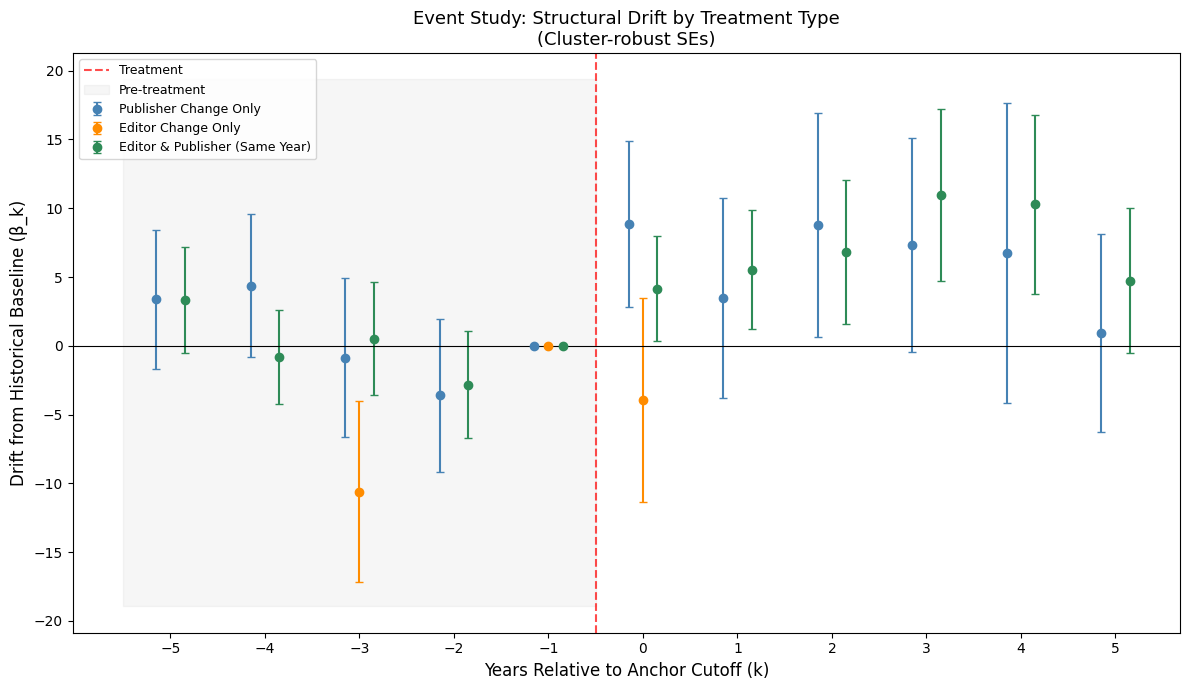

In [29]:
# regression — multi-treatment DID
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the structural drift panel
panel = pd.read_csv('data/panel_structural_drift.csv')

# Updated treatment categories with same/diff year split
TREATMENT_CATEGORIES = [
    'publisher_change_only',
    'editor_change_only',
    'editor_and_publisher_change_same_year',
]

TREATMENT_LABELS = {
    'publisher_change_only': 'Publisher Change Only',
    'editor_change_only': 'Editor Change Only',
    'editor_and_publisher_change_same_year': 'Editor & Publisher (Same Year)',
}

TREATMENT_COLORS = {
    'publisher_change_only': 'steelblue',
    'editor_change_only': 'darkorange',
    'editor_and_publisher_change_same_year': 'seagreen',
}

# ---- Rebuild treatment dummies for the new split ----
for cat in TREATMENT_CATEGORIES:
    panel[f'is_{cat}'] = (panel['category'] == cat).astype(int)

panel['is_treated'] = panel['category'].isin(TREATMENT_CATEGORIES)

# Rebuild Post x Treatment interactions
for cat in TREATMENT_CATEGORIES:
    panel[f'Post_x_{cat}'] = panel['Post_it'] * panel[f'is_{cat}']

# =============================================================================
# Model 1: Static DiD — Separate coefficients per treatment arm
# =============================================================================
post_x_terms = [f'Post_x_{cat}' for cat in TREATMENT_CATEGORIES]
reg_data = panel[['Newspaper_ID', 'Year', 'Y_it'] + post_x_terms].dropna().copy()

news_dummies = pd.get_dummies(reg_data['Newspaper_ID'], prefix='news', drop_first=True, dtype=float)
year_dummies = pd.get_dummies(reg_data['Year'], prefix='yr', drop_first=True, dtype=float)
X_static = pd.concat([reg_data[post_x_terms].reset_index(drop=True),
                       news_dummies.reset_index(drop=True),
                       year_dummies.reset_index(drop=True)], axis=1)
X_static = sm.add_constant(X_static)
y_static = reg_data['Y_it'].reset_index(drop=True)
groups_static = reg_data['Newspaper_ID'].reset_index(drop=True)

static_model = sm.OLS(y_static, X_static).fit(
    cov_type='cluster', cov_kwds={'groups': groups_static}
)

print("=" * 70)
print("MODEL 1: STATIC DiD — Treatment Effects by Group")
print("=" * 70)

for cat in TREATMENT_CATEGORIES:
    var = f'Post_x_{cat}'
    if var not in static_model.params:
        print(f"\n  {TREATMENT_LABELS[cat]}: (no observations or collinear — skipped)")
        continue
    ci = static_model.conf_int().loc[var]

    print(f"\n  {TREATMENT_LABELS[cat]}:")
    print(f"    β:              {static_model.params[var]:.4f}")
    print(f"    Std Error (CR): {static_model.bse[var]:.4f}")
    print(f"    95% CI (CR):    [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"    P-value (CR):   {static_model.pvalues[var]:.4f}")

print(f"\n  R-squared:    {static_model.rsquared:.4f}")
print(f"  Observations: {int(static_model.nobs)}")

# =============================================================================
# Model 2: Event Study (Dynamic Effects) — per treatment arm
# =============================================================================
K_MIN, K_MAX = -5, 5
REF_K = -1
MIN_NEWSPAPERS = 8

panel['Time_to_Treat'] = panel['Year'] - panel['Anchor_Cutoff_Year']

def bin_time(k):
    if pd.isna(k):
        return None
    if k < K_MIN:
        return K_MIN
    if k > K_MAX:
        return K_MAX
    return int(k)

panel['event_k'] = panel['Time_to_Treat'].apply(bin_time)

# Create interaction dummies: event_k × treatment_group
# Only include k/treatment combos with >= MIN_NEWSPAPERS distinct newspapers
interaction_cols = []
dropped_interactions = []

for cat in TREATMENT_CATEGORIES:
    is_cat = panel[f'is_{cat}']
    for k in range(K_MIN, K_MAX + 1):
        if k == REF_K:
            continue

        mask = (panel['event_k'] == k) & (is_cat == 1)
        n_newspapers = panel.loc[mask, 'Newspaper_ID'].nunique()

        k_label = f'n{abs(k)}' if k < 0 else str(k)
        col_name = f'ev_{cat}_k{k_label}'

        if n_newspapers >= MIN_NEWSPAPERS:
            panel[col_name] = mask.astype(int)
            interaction_cols.append(col_name)
        else:
            dropped_interactions.append((cat, k, n_newspapers))

if dropped_interactions:
    print("\n" + "-" * 70)
    print(f"DROPPED event-study interactions (fewer than {MIN_NEWSPAPERS} newspapers):")
    print("-" * 70)
    for cat, k, n in dropped_interactions:
        print(f"  {TREATMENT_LABELS[cat]}, k={k:+d}: {n} newspapers")

reg_data_es = panel[['Newspaper_ID', 'Year', 'Y_it'] + interaction_cols].dropna().copy()

news_dummies_es = pd.get_dummies(reg_data_es['Newspaper_ID'], prefix='news', drop_first=True, dtype=float)
year_dummies_es = pd.get_dummies(reg_data_es['Year'], prefix='yr', drop_first=True, dtype=float)
X_es = pd.concat([reg_data_es[interaction_cols].reset_index(drop=True),
                   news_dummies_es.reset_index(drop=True),
                   year_dummies_es.reset_index(drop=True)], axis=1)
X_es = sm.add_constant(X_es)
y_es = reg_data_es['Y_it'].reset_index(drop=True)
groups_es = reg_data_es['Newspaper_ID'].reset_index(drop=True)

event_model = sm.OLS(y_es, X_es).fit(
    cov_type='cluster', cov_kwds={'groups': groups_es}
)

# Extract coefficients per treatment group
print("\n" + "=" * 70)
print("MODEL 2: EVENT STUDY — Dynamic Effects by Treatment Group")
print("=" * 70)

all_coefs = {}
for cat in TREATMENT_CATEGORIES:
    coefs = []
    for k in range(K_MIN, K_MAX + 1):
        if k == REF_K:
            coefs.append({'k': k, 'beta': 0, 'ci_low': 0, 'ci_high': 0,
                          'pval_CR': np.nan})
            continue

        k_label = f'n{abs(k)}' if k < 0 else str(k)
        col = f'ev_{cat}_k{k_label}'

        # Skip if this interaction was dropped due to too few newspapers
        if col not in interaction_cols:
            continue

        if col in event_model.params:
            ci = event_model.conf_int().loc[col]
            coefs.append({
                'k': k,
                'beta': event_model.params[col],
                'ci_low': ci[0],
                'ci_high': ci[1],
                'pval_CR': event_model.pvalues[col],
            })

    coef_df = pd.DataFrame(coefs)
    all_coefs[cat] = coef_df

    print(f"\n  {TREATMENT_LABELS[cat]}:")
    print(coef_df.to_string(index=False, float_format='{:.4f}'.format))

# --- Formal pre-trend joint F-test per arm ---
print("\n" + "-" * 70)
print("PRE-TREND JOINT F-TESTS (H0: all pre-treatment coefficients = 0)")
print("-" * 70)
for cat in TREATMENT_CATEGORIES:
    pre_cols = []
    for k in range(K_MIN, REF_K):
        k_label = f'n{abs(k)}'
        col = f'ev_{cat}_k{k_label}'
        if col in event_model.params:
            pre_cols.append(col)
    if len(pre_cols) == 0:
        print(f"  {TREATMENT_LABELS[cat]}: no pre-treatment coefficients found")
        continue
    R_mat = np.zeros((len(pre_cols), len(event_model.params)))
    for i, col in enumerate(pre_cols):
        idx = list(event_model.params.index).index(col)
        R_mat[i, idx] = 1
    try:
        f_result = event_model.f_test(R_mat)
        print(f"  {TREATMENT_LABELS[cat]}: F={float(f_result.fvalue):.3f}, p={float(f_result.pvalue):.4f}")
    except Exception as e:
        print(f"  {TREATMENT_LABELS[cat]}: F-test failed ({e})")

# =============================================================================
# Plot: Overlaid event-study paths
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

n_cats = len(TREATMENT_CATEGORIES)
offsets = {cat: -0.15 + i * (0.3 / max(n_cats - 1, 1))
           for i, cat in enumerate(TREATMENT_CATEGORIES)}

for cat in TREATMENT_CATEGORIES:
    cdf = all_coefs[cat]
    if cdf.empty:
        continue
    color = TREATMENT_COLORS[cat]
    label = TREATMENT_LABELS[cat]
    offset = offsets[cat]

    ax.errorbar(
        cdf['k'] + offset, cdf['beta'],
        yerr=[cdf['beta'] - cdf['ci_low'], cdf['ci_high'] - cdf['beta']],
        fmt='o', capsize=3, color=color, markersize=6, linewidth=1.5,
        label=label
    )

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=-0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Treatment')
ax.fill_betweenx(
    y=ax.get_ylim(), x1=K_MIN - 0.5, x2=-0.5,
    alpha=0.07, color='gray', label='Pre-treatment'
)

ax.set_xlabel('Years Relative to Anchor Cutoff (k)', fontsize=12)
ax.set_ylabel('Drift from Historical Baseline (β_k)', fontsize=12)
ax.set_title('Event Study: Structural Drift by Treatment Type\n(Cluster-robust SEs)', fontsize=13)
ax.set_xticks(range(K_MIN, K_MAX + 1))
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('figures/structural_drift_event_study.png', dpi=150)
plt.show()

In [30]:
df = pd.read_csv('data/final_list.csv')
df[df.category.str.contains('sufficient')]

,newspapers_all_years_name,issn,master_name,master_id,publisher_change_year,editor_change_year,category
24,the daily gazette,2474-2031,GAZETTE,11484.0,NaN,NaN,insufficient_data
31,telegram-herald,2378-0703,TELEGRAMM-HERALD,24858.0,NaN,NaN,insufficient_data
56,evening capital,2643-8593,EVENING CAPITAL,22134.0,NaN,NaN,insufficient_data
77,the rutland daily globe,2328-3432,Globe,6167.0,NaN,NaN,insufficient_data
78,mower county transcript,2332-7340,MOWER CO . TRANSCRIPT,25775.0,NaN,NaN,insufficient_data
...,...,...,...,...,...,...,...
508,watauga democrat,0745-1903,Watauga Democrat,48096.0,NaN,NaN,insufficient_data
510,copiah signal,2765-8538,COPIAH SIGNAL,26855.0,NaN,NaN,insufficient_data
514,the mesilla valley independent,2474-9982,MESILLA VALLEY INDEPENDENT,31587.0,NaN,NaN,insufficient_data
515,the hazlehurst signal,2765-8317,SIGNAL,26856.0,NaN,NaN,insufficient_data
